In [5]:
import os
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, concatenate, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, Dropout, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from PIL import Image
import os, glob, sys
import numpy as np
from sklearn.model_selection import train_test_split # 섞어줌
from keras.utils import np_utils

In [2]:
!echo $COLAB_TPU_ADDR

10.101.168.202:8470


In [3]:
import tensorflow as tf

# TPU gRPC 접근 URI
TPU_PATH = f"grpc://{os.environ['COLAB_TPU_ADDR']}"

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=TPU_PATH)
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.101.168.202:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.101.168.202:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


In [4]:
strategy = tf.distribute.experimental.TPUStrategy(resolver)

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [7]:
# CNN에서 분류한 데이터를 가져온다.
X_train, X_test, y_train, y_test = np.load('/content/drive/MyDrive/git/4_categorical_100.npy', allow_pickle=True)

# 정규화
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [8]:
def model_inception():

    # 1. input shape
    input_img = Input(shape = X_train.shape[1:])

    # 2. output1
    branch_1_1 = Conv2D(96, (1,1), padding="same", activation="relu")(input_img)
    branch_1_2 = Conv2D(64, (1,1), padding="same", activation="relu")(input_img)
    branch_1_2 = Conv2D(96, (3,3), padding="same", activation="relu")(branch_1_2)
    branch_1_3 = Conv2D(64, (1,1), padding="same", activation="relu")(input_img)
    branch_1_3 = Conv2D(96, (3,3), padding="same", activation="relu")(branch_1_3)
    branch_1_3 = Conv2D(96, (3,3), padding="same", activation="relu")(branch_1_3)
    branch_1_4 = MaxPooling2D((3,3), strides = (1,1), padding = "same")(input_img)
    branch_1_4 = Conv2D(96, (1,1), padding="same", activation="relu")(branch_1_4)

    output1 = concatenate([branch_1_1, branch_1_2, branch_1_3, branch_1_4 ], axis = 3)

    # 3. output2
    branch_2_1 = Conv2D(96, (1,1), padding="same", activation="relu")(output1)
    branch_2_2 = Conv2D(64, (1,1), padding="same", activation="relu")(output1)
    branch_2_2 = Conv2D(96, (3,3), padding="same", activation="relu")(branch_2_2)
    branch_2_3 = Conv2D(64, (1,1), padding="same", activation="relu")(output1)
    branch_2_3 = Conv2D(96, (3,3), padding="same", activation="relu")(branch_2_3)
    branch_2_3 = Conv2D(96, (3,3), padding="same", activation="relu")(branch_2_3)
    branch_2_4 = MaxPooling2D((3,3), strides = (1,1), padding = "same")(output1)
    branch_2_4 = Conv2D(96, (1,1), padding="same", activation="relu")(branch_2_4)

    output2 = concatenate([branch_2_1, branch_2_2, branch_2_3, branch_2_4 ], axis = 3)

    # 4. output3
    branch_3_1 = Conv2D(96, (1,1), padding="same", activation="relu")(output2)
    branch_3_2 = Conv2D(64, (1,1), padding="same", activation="relu")(output2)
    branch_3_2 = Conv2D(96, (3,3), padding="same", activation="relu")(branch_3_2)
    branch_3_3 = Conv2D(64, (1,1), padding="same", activation="relu")(output2)
    branch_3_3 = Conv2D(96, (3,3), padding="same", activation="relu")(branch_3_3)
    branch_3_3 = Conv2D(96, (3,3), padding="same", activation="relu")(branch_3_3)
    branch_3_4 = MaxPooling2D((3,3), strides = (1,1), padding = "same")(output2)
    branch_3_4 = Conv2D(96, (1,1), padding="same", activation="relu")(branch_3_4)

    output3 = concatenate([branch_3_1, branch_3_2, branch_3_3, branch_3_4 ], axis = 3)

    # 5. GlobalAveragePooling
    output = GlobalAveragePooling2D(name='avg_pool')(output3)

    # 6. classification
    out = Dense(4, activation="softmax")(output)

    model = Model(inputs = input_img, outputs = out)

    return model

In [9]:
model_inception().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 100, 100, 64  256         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 100, 100, 64  256         ['input_1[0][0]']                
                                )                                                             

In [10]:
with strategy.scope():

    # val_loss를 기준으로, 10번 이상 v학습이 개선되지 않을시, early stop 한다. 
    early_stopping = EarlyStopping(monitor='val_loss', patience=10) 

    # 3개 이상 분류이고, 원 핫 인코딩이 아니므로 손실함수는 sparse_catergorical_crossentropy
    model = model_inception()
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    history = model.fit(X_train, y_train, callbacks=[early_stopping], batch_size=50, validation_data = (X_test,y_test), epochs = 100)

Epoch 1/100
Instructions for updating:
use `experimental_local_results` instead.


Instructions for updating:
use `experimental_local_results` instead.


182/182 [==============================] - 48s 172ms/step - loss: 1.3155 - accuracy: 0.3538 - val_loss: 1.2887 - val_accuracy: 0.4016
Epoch 2/100
182/182 [==============================] - 16s 88ms/step - loss: 1.2692 - accuracy: 0.4004 - val_loss: 1.2917 - val_accuracy: 0.3482
Epoch 3/100
182/182 [==============================] - 16s 88ms/step - loss: 1.2233 - accuracy: 0.4311 - val_loss: 1.2100 - val_accuracy: 0.4916
Epoch 4/100
182/182 [==============================] - 16s 89ms/step - loss: 1.1627 - accuracy: 0.4793 - val_loss: 1.1340 - val_accuracy: 0.4965
Epoch 5/100
182/182 [==============================] - 16s 88ms/step - loss: 1.0870 - accuracy: 0.5267 - val_loss: 1.0570 - val_accuracy: 0.5450
Epoch 6/100
182/182 [==============================] - 16s 89ms/step - loss: 1.0500 - accuracy: 0.5528 - val_loss: 0.9978 - val_accuracy: 0.5717
Epoch 7/100
182/182 [==============================] - 16s 89ms/step - loss: 0.9943 - accuracy: 0.5854 - val_loss: 0.9924 - val_accuracy: 0.6

<Figure size 432x288 with 0 Axes>

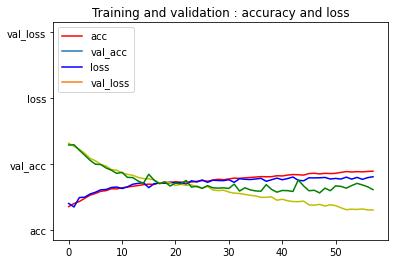

<Figure size 432x288 with 0 Axes>

In [11]:
# 정확도와 loss 차트 그리기
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

# history의 train과 test의 정확도와 loss를 각각 가져온다.
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # 에포크

# 그래프로 표시
plt.plot(epochs, acc, 'r', "acc")
plt.plot(epochs, val_acc, 'b', "val_acc")
plt.plot(epochs, loss, 'y', "loss")
plt.plot(epochs, val_loss, 'g', "val_loss")
plt.legend(['acc','val_acc','loss','val_loss'], loc = 'upper left')

plt.title('Training and validation : accuracy and loss')
plt.figure()